<a href="https://colab.research.google.com/github/GrigoryBartosh/dul_2021/blob/main/Homework/hw15/Homework15_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install denoising_diffusion_pytorch

# Imports

In [2]:
import copy

import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
import torch.distributions as D
from torch import autograd

from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

from denoising_diffusion_pytorch import Unet

import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange

In [3]:
import random

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

# Data

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((16, 16)),
    transforms.Normalize((0.5), (0.5)),
])

In [6]:
train_data = MNIST(root='./data/', train=True, download=True, transform=transform)
val_data = MNIST(root='./data/', train=False, download=True, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [7]:
BATCH_SIZE = 128

In [8]:
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    drop_last=True
)
val_loader = DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    drop_last=True
)

# Utils

In [9]:
def f_(f, x):
    x = x.clone()
    
    with torch.enable_grad():
        if not x.requires_grad:
            x.requires_grad = True

        y = f(x)
        
        (grad, ) = autograd.grad(y.sum(), x, create_graph=False)
        
    return grad

In [10]:
@torch.no_grad()
def solve_sde(x, f, g, ts=0, tf=1, dt=1e-3):
    for t in tqdm(np.arange(ts, tf, dt)):
        tt = torch.FloatTensor([t]).to(device)
        z = torch.randn_like(x).to(device)
        x = x + f(x, tt) * dt + g(tt) * z * abs(dt) ** 0.5
        
    return x

In [11]:
@torch.no_grad()
def show_imgs(x):
    x = x.detach().cpu()
    
    img = make_grid(x, nrow=5)
    img = img.permute(1, 2, 0)
    img = img * 0.5 + 0.5

    plt.imshow(img.numpy())
    plt.axis('off')
    plt.show()

# Question 1. DDPM

В этом задание вам предлагается реализовать диффузную модель с непрерывным временем на основе DDPM. Технический код уже написан, нужно лишь восстановить содержательные функции.

In [12]:
class ContDDPM(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.eps_th = Unet(
            dim=16,
            dim_mults=(1, 2, 3),
            channels=1
        )
        
    def device(self):
        return next(self.parameters()).device
        
    def gamma(self, t):
        return torch.log(torch.expm1(1e-4 + 10 * t ** 2))
    
    # Coefficient \bar{a}_t
    # see presentation, slide 19
    def a_bar(self, t):
        g = self.gamma(t)
        return torch.sigmoid(-g)
    
    def sigma_2(self, t):
        return 1 - self.a_bar(t)
    
    def log_a_bar_sqrt_(self, t):
        return 0.5 * f_(lambda s: torch.log(self.a_bar(s)), t)
    
    # Coefficient f(x, t)
    # see presentation, slide 31
    def f(self, x_t, t):
        return self.log_a_bar_sqrt_(t) * x_t
    
    # Coefficient g^2(t)
    # see presentation, slide 31
    def g_2(self, t):
        return f_(self.sigma_2, t) - 2 * self.log_a_bar_sqrt_(t) * self.sigma_2(t)
    
    def std(self, t):
        return torch.sqrt(self.sigma_2(t)).reshape((-1, 1, 1, 1))

    # Learned score function
    # see presentation, slide 28
    def score(self, x_t, t):
        """
        x_t: tensort [bs, 1, 16, 16]
        t: tensort [bs]

        Returns
        - score: tensor  [bs, 1, 16, 16]
        """
        return - self.eps_th(x_t, t) / self.std(t)
    
    def sample_t(self, bs):
        device = self.device()
        t = torch.rand(bs).to(device)
        return t
        
    # Transition sampling q(x_t|x_0)
    # see presentation, slide 19 and 25
    def sample_x_t(self, x_0, t):
        """
        x_0: tensort [bs, 1, 16, 16]
        t: tensort [bs]

        Returns
        - x_t: tensor  [bs, 1, 16, 16]
        - eps: accumulated noise tensor [bs, 1, 16, 16]
        """
        eps = torch.randn_like(x_0)
        noise = eps * self.std(t)
        x_t = x_0 * torch.sqrt(self.a_bar(t)).reshape((-1, 1, 1, 1)) 
        x_t = x_t + noise

        return x_t, eps

    # Loss function
    # see presentation, slide 26
    def get_loss(self, x_0):
        device = self.device()
        bs, C, H, W = x_0.shape
        data_dims = tuple(np.arange(1, len(x_0.shape)))
        
        t = self.sample_t(bs)
        x_t, eps = self.sample_x_t(x_0, t)

        eps = torch.flatten(eps, 1)
        pred = torch.flatten(self.eps_th(x_t, t), 1)

        loss = F.mse_loss(eps, pred) * C * H * W
        
        return loss
        
    # Sampling according to reverse SDE
    # see presentation, slide 32
    # Hint: use solve_sde function
    def sample_sde(self, bs, dt=1e-3):
        """
        bs: int

        Returns
        - x_0: tensor  [bs, 1, 16, 16] generated data
        """
        x_T = torch.randn((bs, 1, 16, 16), device=device)
        
        def f(x, t):
          g2 = self.g_2(t).reshape((-1, 1, 1, 1))
          return self.f(x, t) - g2 * self.score(x, t)
        
        def g(t):
          return torch.sqrt(self.g_2(t))

        return solve_sde(x_T, f, g, 1, 0, -dt)

## Training

In [13]:
def calc_loss(ddpm, x):
    loss = ddpm.get_loss(x)

    return loss

In [14]:
def train_step(ddpm, x, optim):
    loss_total = calc_loss(ddpm, x)
    
    optim.zero_grad()
    loss_total.backward()
    optim.step()
    
    return loss_total.item()

In [15]:
def train_epoch(ddpm, data_loader, optim):
    ddpm.train()

    losses = []
    for x, _ in data_loader:
        x = x.to(device)

        loss_total = train_step(ddpm, x, optim)
        
        losses.append(loss_total)
        
    loss_mean = np.mean(losses)
    return loss_mean

In [16]:
def val_epoch(ddpm, data_loader):
    ddpm.eval()

    losses = []
    for x, _ in data_loader:
        x = x.to(device)

        total_loss = calc_loss(ddpm, x).item()
        
        losses.append(total_loss)
        
    loss_mean = np.mean(losses)

    return loss_mean

In [17]:
def train(ddpm, train_loader, val_loader, optim, epochs):
    for epoch in trange(epochs):
        train_loss = train_epoch(ddpm, train_loader, optim)
        with torch.no_grad():
          val_loss = val_epoch(ddpm, val_loader)
        print(f"train: {train_loss:.5f}    val: {val_loss:.5f}")

## Experiment

In [ ]:
ddpm = ContDDPM()
ddpm.to(device)

optim = torch.optim.Adam(ddpm.parameters(), lr=2e-4)

train(ddpm, train_loader, val_loader, optim, epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

train: 59.83199340461666    val: 23.58879575973902
train: 20.964037518215996    val: 19.898839767162617
train: 18.325487658508823    val: 17.31512409601456
train: 16.868308760162094    val: 16.492643270737087
train: 15.903967961286886    val: 15.494083759112236
train: 15.07063913345337    val: 14.360071622408354
train: 14.376342557434343    val: 14.209193914364546
train: 13.872333681481516    val: 13.488511611253788
train: 13.341608705683651    val: 13.243576758947128
train: 13.169116537795107    val: 13.005252067859356


In [ ]:
train(ddpm, train_loader, val_loader, optim, epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

train: 12.741141225537683    val: 12.974769470019218
train: 12.759594603481455    val: 12.382879782945682
train: 12.48958353507213    val: 12.031552693782709
train: 12.427481732816778    val: 12.059634881141859
train: 12.084511106849735    val: 11.904150082514835
train: 12.052137972962143    val: 11.653542885413536
train: 11.934240266808079    val: 11.83611468779735
train: 11.880971097538614    val: 11.708924452463785
train: 11.81882427390824    val: 11.783044008108286
train: 11.709941633746155    val: 11.318116567073725


### 20 epochs

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


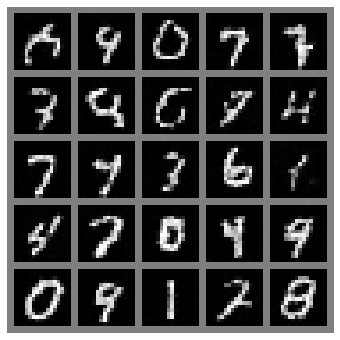

In [ ]:
# After 20 epochs
x = ddpm.sample_sde(bs=25, dt=1e-3)

plt.rcParams["figure.figsize"] = [6., 6.]
show_imgs(x)

### 30 epochs

In [ ]:
train(ddpm, train_loader, val_loader, optim, epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

train: 11.66113738524608    val: 11.30709579663399
train: 11.4952181903725    val: 11.29244735913399
train: 11.36943149770427    val: 11.879519621531168
train: 11.321391578413483    val: 11.483508990361141
train: 11.288622972292778    val: 11.175197711357704
train: 11.184863965735476    val: 11.467238071637276
train: 11.159703140584831    val: 10.789306408319717
train: 10.976197675762014    val: 10.895228434831669
train: 11.07738862078414    val: 11.269018668394823
train: 10.9075470215235    val: 10.8786120170202


  0%|          | 0/200 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


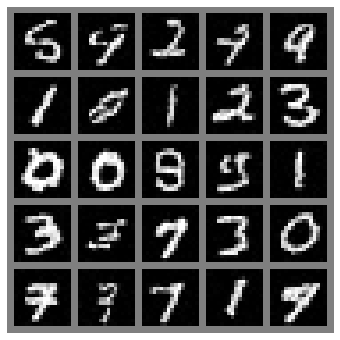

In [ ]:
# After 30 epochs
x = ddpm.sample_sde(bs=25, dt=5e-3)

plt.rcParams["figure.figsize"] = [6., 6.]
show_imgs(x)

# Bonus. Conditional generation

На паре мы обсуждали возможность делать условную генерацию с помощью диффузных моделей (см. презентацию, слайд 35). Бонусное задание - реализовать генерацию с условием на класс. Для этого нужно:

*   Обучить безусловную генерацию из первого задания
*   Обучить классификатор обусловленный на время
*   Собрать все вместе



## Classifier

In [67]:
class TimeResBlock(nn.Module):
  def __init__(self, in_channels, out_channels, emb_size=16):
    super().__init__()
    self.time_mlp = nn.Linear(emb_size, in_channels)
    
    self.skip_conv = nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(out_channels))
    
    self.main_conv = nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(out_channels),
                                   nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(out_channels))
    
  def forward(self, data):
    x, time = data

    emb = self.time_mlp(time)
    emb = emb.view((-1, x.shape[1], 1, 1))

    return (self.main_conv(x + emb) + self.skip_conv(x), time)

In [68]:
class SinusoidalPosEmb(nn.Module):
  def __init__(self, dim=16):
    super().__init__()
    half_dim = dim // 2
    self.emb = np.log(10000) / (half_dim - 1)
    self.emb = torch.exp(torch.arange(half_dim, device=device) * -self.emb)[None, :]
  
  def forward(self, x):
    emb = x[:, None] * self.emb
    emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
    return emb

In [69]:
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.sin_emb = SinusoidalPosEmb()

    self.conv = nn.Sequential(TimeResBlock(1, 32),
                              # 8 x 8
                              TimeResBlock(32, 64),
                              # 4 x 4
                              TimeResBlock(64, 64),
                              # 2 x 2
                              TimeResBlock(64, 64))

    self.lin = nn.Sequential(nn.Flatten(),
                             nn.Linear(64, 128),
                             nn.ReLU(),
                             nn.Linear(128, 10))

  def forward(self, x_t, t):
    time_emb = self.sin_emb(t)

    x_t, _ = self.conv((x_t, time_emb))
    
    return self.lin(x_t)

## Models, hyperparameters

In [21]:
clf = Classifier().to(device)
ddpm = ContDDPM().to(device)

n_epochs = 10
batch_size = BATCH_SIZE

In [71]:
from torch.optim import Adam

opt = Adam(clf.parameters(), 1e-4)
ces = nn.CrossEntropyLoss()

## Train classifier

In [72]:
for epoch in range(n_epochs):
  clf.train()
  for i, (x, y) in enumerate(train_loader):
    x = x.to(device)
    y = y.to(device)
   
    t = ddpm.sample_t(batch_size)
    x_t, _ = ddpm.sample_x_t(x, t)

    loss = ces(clf(x_t, t), y)

    opt.zero_grad()
    loss.backward()
    opt.step()

  with torch.no_grad():
    clf.eval()
    acc = 0
    for x, y in val_loader:
      x = x.to(device)
      y = y.to(device)

      t = ddpm.sample_t(batch_size)
      
      t = torch.clip(t, 0., 0.3)
      # [0.; 0.1] -- > accuracy around 0.93
      # [0.; 0.4] -- > accuracy around 0.67

      x_t, _ = ddpm.sample_x_t(x, t)

      pred = torch.argmax(clf(x_t, t), dim=-1)
      acc += (pred == y).sum().cpu().item()

    acc /= batch_size * len(val_loader)

  print(f"EPOCH : {epoch}")
  print(f"\t accuracy -- {acc:.5f}")

EPOCH : 0
	 accuracy -- 0.68840
EPOCH : 1
	 accuracy -- 0.75561
EPOCH : 2
	 accuracy -- 0.78425
EPOCH : 3
	 accuracy -- 0.79637
EPOCH : 4
	 accuracy -- 0.80829
EPOCH : 5
	 accuracy -- 0.82051
EPOCH : 6
	 accuracy -- 0.82432
EPOCH : 7
	 accuracy -- 0.82782
EPOCH : 8
	 accuracy -- 0.83143
EPOCH : 9
	 accuracy -- 0.83323


## Train DDPM

In [24]:
optim = torch.optim.Adam(ddpm.parameters(), lr=2e-4)
train(ddpm, train_loader, val_loader, optim, epochs=15)

  0%|          | 0/15 [00:00<?, ?it/s]

train: 57.15846    val: 24.65790
train: 21.49344    val: 19.53542
train: 18.23555    val: 17.28590
train: 16.33731    val: 15.71842
train: 15.40628    val: 15.15691
train: 14.72790    val: 14.12478
train: 14.45034    val: 14.08404
train: 13.92862    val: 13.65426
train: 13.70047    val: 13.57597
train: 13.32631    val: 13.47423
train: 13.18824    val: 12.80713
train: 12.98123    val: 13.60351
train: 12.94110    val: 12.71867
train: 12.73422    val: 13.14692
train: 12.49815    val: 12.17258


## Sampling with ddpm only

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


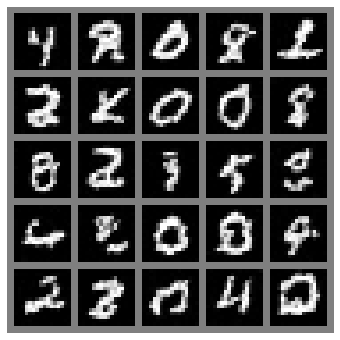

In [27]:
with torch.no_grad():
  x = ddpm.sample_sde(bs=25, dt=1e-3)

plt.rcParams["figure.figsize"] = [6., 6.]
show_imgs(x)

## Sampling with classifier and ddpm

In [28]:
def solve_sde(x, f, g, ts=0, tf=1, dt=1e-3):
    for t in tqdm(np.arange(ts, tf, dt)):
        tt = torch.FloatTensor([t]).to(device)
        z = torch.randn_like(x)
        x = x + f(x, tt) * dt + g(tt) * z * abs(dt) ** 0.5

    return x

In [74]:
def conditional_sample(bs, threshold=0.3, cls=None, dt=1e-3):
  """
  bs: int
  threshold: float
  cls: int
  dt: float
  
  Returns
  - x_0: tensor  [bs, 1, 16, 16] generated data
  """
  x_T = torch.randn((bs, 1, 16, 16), device=device)
  grad_out = torch.ones((bs,), device=device)

  def f(x, t):
    g2 = ddpm.g_2(t).reshape((-1, 1, 1, 1))

    with torch.no_grad():
      base_f = ddpm.f(x, t)
      base_score = ddpm.score(x, t)
    
    if t > threshold:
      return base_f - g2 * base_score
    else:
      z = x.detach()
      z.requires_grad = True
      cond_grad = torch.autograd.grad(clf(z, t)[:, cls], z, grad_outputs=grad_out)[0]
      z.requires_grad = False
      del z
      return base_f - g2 * (base_score + 3 * cond_grad)
  
  def g(t):
    return torch.sqrt(ddpm.g_2(t))

  return solve_sde(x_T, f, g, 1, 0, -dt)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


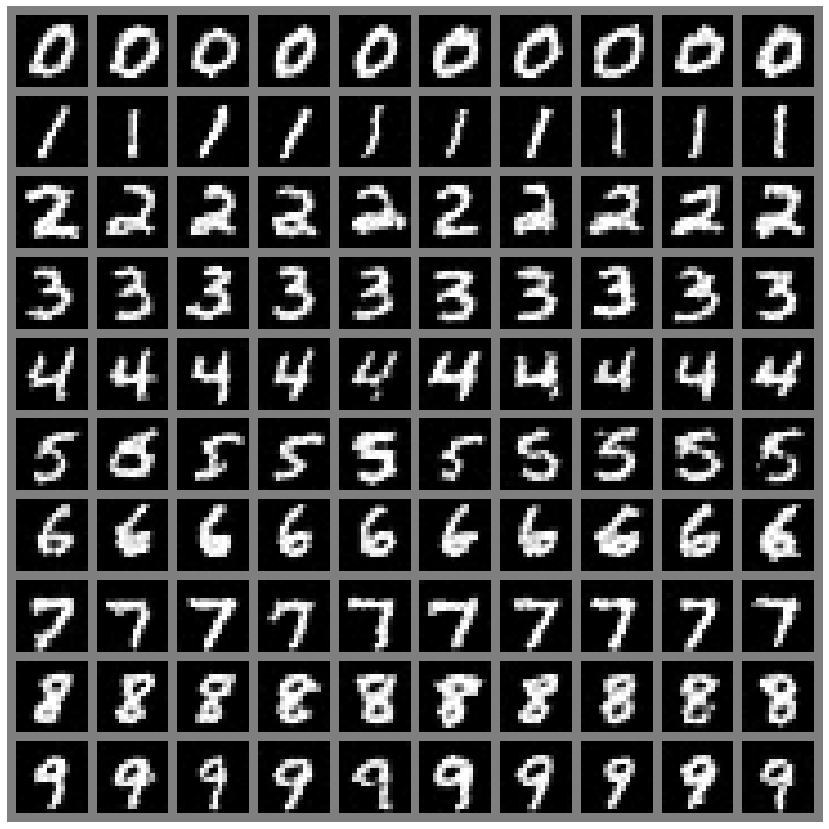

In [76]:
x = torch.empty((10, 10, 1, 16, 16), device=device)
for i in range(10):
  x[i] = conditional_sample(bs=10, threshold=0.9, cls=i, dt=4e-3)
x = x.reshape(-1, 1, 16, 16)

x = x.detach().cpu()
img = make_grid(x, nrow=10)
img = img.permute(1, 2, 0)
img = img * 0.5 + 0.5

plt.rcParams["figure.figsize"] = [15., 15.]
plt.imshow(img.numpy())
plt.axis('off')
plt.show()